In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [179]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = 2

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
a11 = 1
a22 = 1

f = lambda x, y: 2 * x * (x - 1)**2 * (3*y - 4) + 2*(3*x - 2)*(y - 2)**2 * y

beta = 1e-5
omega = 1e+5
psi = 0





0.02557373046875

$$
Input interpretation:
\frac{\partial^{2}\left((x-1)^{2}(y-2)^{2} x y\right)}{\partial x^{2}}+\frac{\partial^{2}\left((x-1)^{2}(y-2)^{2} x y\right)}{\partial y^{2}}
$$
$$
Result:
2 x(x-1)^{2}(3 y-4)+2(3 x-2)(y-2)^{2} y
$$

$\phi$ 

---
##### (d^2/dx^2  (x - 1)^2 * (y - 2)^2) + (d^2/dy^2 (x - 1)^2 * (y - 2)^2) )

In [149]:
nx = 16
ny = 32
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [150]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

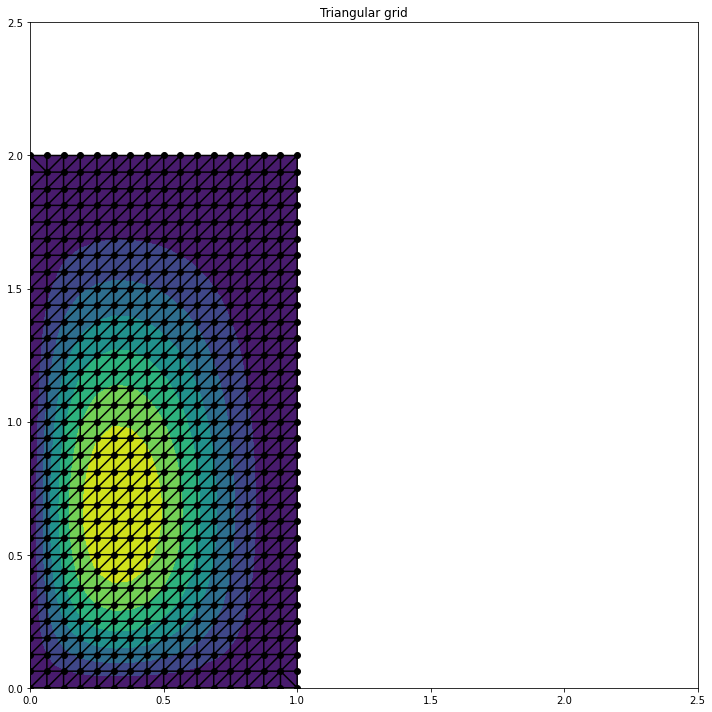

In [151]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))#plt.subplots(nrows=2, ncols=2)

plt.xlim(0, 2.5)
plt.ylim(0, 2.5)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.show()

In [152]:
a = np.array([[1, 2]])
if np.array([1, 1]) in a:
    print(1)

1


In [185]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area / 3

def K_i(b, c, s, a11, a22):
    K = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            K[i][j] = a11 * (b[i] * b[j]) + a22 * (c[i] * c[j])
    K /= 4 * s
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]
            
def fill_F_with_phi_i(F, tri, points=points, Me=[]):
    Qe = Me.dot(
        np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]])
    )

    for i in range(3):
        F[tri[i]] += Qe[i][0]
#     for i, (p_i, phi_i) in enumerate(zip(tri, phi)):
#         F[p_i] += s/12 * f(*points[p_i])
#         #phi_i * f(*points[p_i]) 

In [ ]:
print

In [225]:
G = h / ny

Re = (omega*G)/(6*beta) * np.array([[2, 1], [1, 2]])
Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = ((s)/(12)) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    boundary_points = np.array([])
    if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == 0]
    elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == w]        
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == 0]
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == h]

    if boundary_points.size:

        boundary_points = boundary_points.tolist()
        if p2 not in boundary_points:
            boundary_points.reverse()

        A[points.index(boundary_points[0])][points.index(boundary_points[0])] += Re[0][0]
        A[points.index(boundary_points[0])][points.index(boundary_points[1])] += Re[0][1]
        A[points.index(boundary_points[1])][points.index(boundary_points[0])] += Re[1][0]
        A[points.index(boundary_points[1])][points.index(boundary_points[1])] += Re[1][1]
        
        F[points.index(boundary_points[0])] += Pe[0]
        F[points.index(boundary_points[1])] += Pe[1]   
        continue
    
    p = [(p1[0] + p2[0] + p3[0])/3, (p1[1] + p2[1] + p3[1])/3] 
    
    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups):
        t1 = group[0]
        t2 = group[1]
        
        b[i][j] = t2[1] - t1[1]
        c[i][j] = t2[0] - t1[0]
        
        # b[i][j] = t1[1] - t2[1]
        # c[i][j] = t2[0] - t1[0]
        # phi[i][j] = (a[i][j] + b[i][j] * p[0] + c[i][j] * p[1]) / delta

    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_F_with_phi_i(F, tri, Me=Me)



array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [217]:
import numpy.linalg as LA
b = LA.solve(A, F)

In [218]:
ex = [u(*p) for p in points]
LA.norm(b - ex)

43.950567717548644

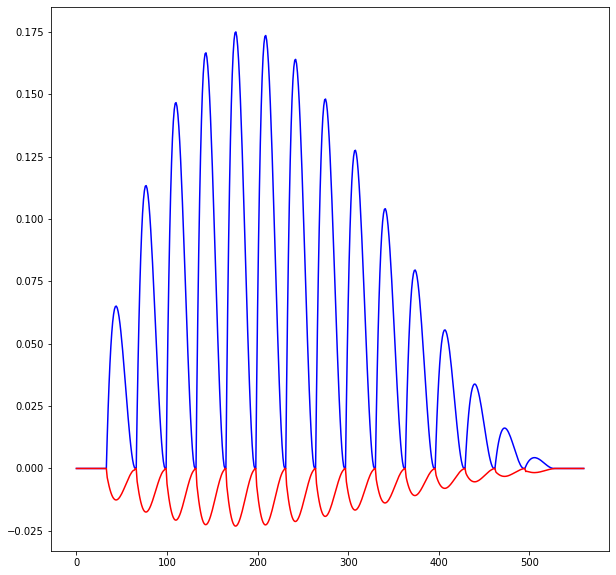

In [219]:
mesh = range(len(b))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(mesh, ex, 'blue')
ax.plot(mesh, b, 'red')

In [220]:
b.shape

(561, 1)

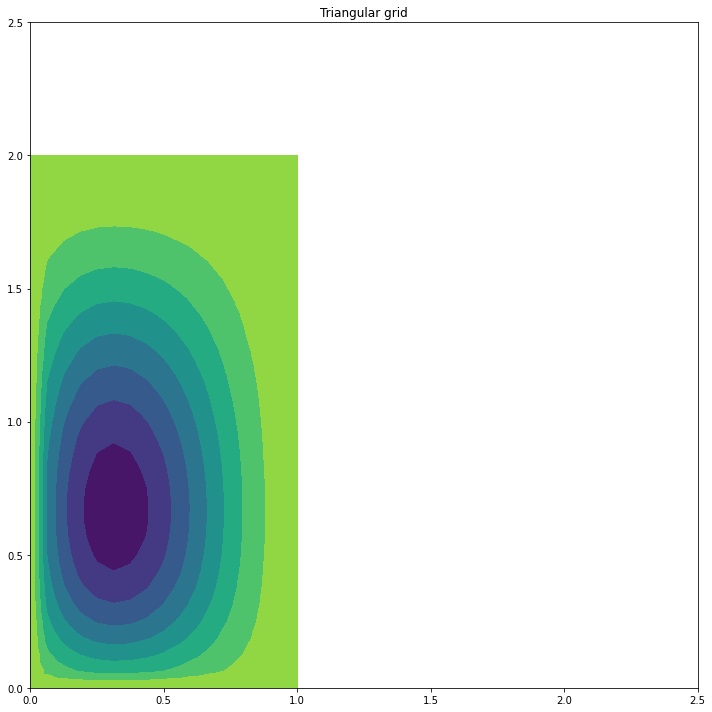

In [221]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = b.ravel()

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))#plt.subplots(nrows=2, ncols=2)

plt.xlim(0, 2.5)
plt.ylim(0, 2.5)

# Plot the triangulation.
ax.tricontourf(triang, z)
# ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.show()

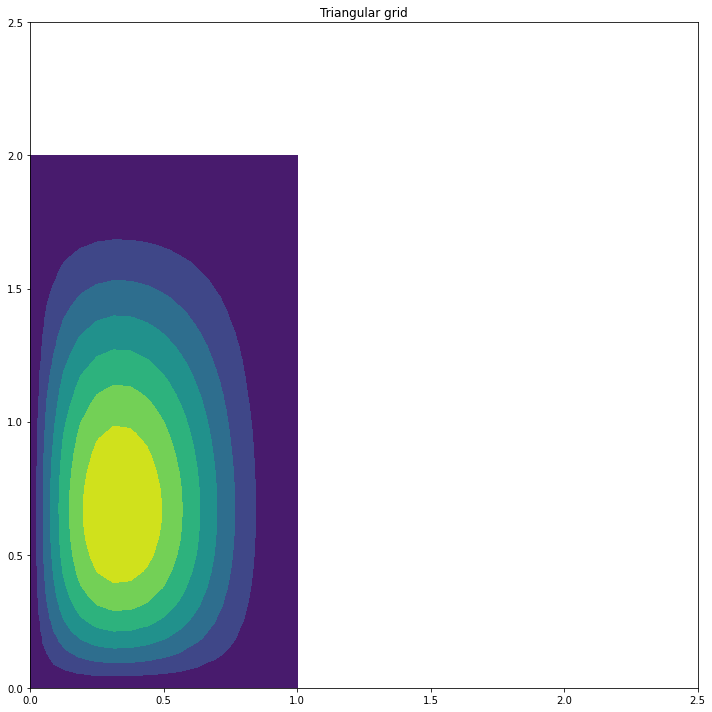

In [222]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, 2.5)
plt.ylim(0, 2.5)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.set_title('Triangular grid')

fig.tight_layout()
plt.show()

In [210]:
# n =  len(triangles)
# triangle_area = rectangle_area / n
# s = triangle_area / 3
# delta = 2 * s * 3

# G = h / ny

# Re = (omega*G)/(6*beta) * np.array([[2, 1], [1, 2]])
# Me = (psi*G)/(2*beta) * np.array([1, 1])
# print(Re)
# print(Me)

# a = np.zeros([n, 3])
# b = np.zeros([n, 3])
# c = np.zeros([n, 3])
# phi = np.zeros([n, 3])

# print("a: ", a.shape)
# print("b: ", a.shape)
# print("c: ", a.shape)


# K = np.zeros([n, 3, 3])
# A = np.zeros([len(points), len(points)])
# F = np.zeros([len(points), 1])

# for i, tri in enumerate(triangles):
    
#     p1 = points[tri[0]]
#     p2 = points[tri[1]] 
#     p3 = points[tri[2]]
    
    
#     if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
#         l = np.array([p1[0], p2[0], p3[0]])
#         boundary_points = l[l == 0]
#     elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
#         l = np.array([p1[0], p2[0], p3[0]])
#         boundary_points = l[l == w]        
#     elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
#         l = np.array([p1[0], p2[0], p3[0]])
#         boundary_points = l[l == 0]
#     elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
#         l = np.array([p1[0], p2[0], p3[0]])
#         boundary_points = l[l == h]
#     else:
#         pass


    
#     p = [(p1[0] + p2[0] + p3[0])/3, (p1[1] + p2[1] + p3[1])/3] 
    
#     groups = [
#         (p2, p3, _), (p3, p1, _), (p2, p1, _)
#     ]
    
#     for j, group in enumerate(groups):
#         t1 = group[0]
#         t2 = group[1]
#         t3 = group[2]
        
#         a[i][j] = t1[0] * t2[1] - t2[0] * t1[1]
#         b[i][j] = t1[1] - t2[1]
#         c[i][j] = t2[0] - t1[0]
        
#         phi[i][j] = (a[i][j] + b[i][j] * p[0] + c[i][j] * p[1]) / delta

#     K[i] = K_i(b[i], c[i], s, a11, a22)
#     fill_A_with_K_i(A, K[i], tri)
#     fill_F_with_phi_i(F, phi[i], tri)

# print(count)


